In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict

In [4]:
api = wandb.Api()

In [ ]:
run_seeds = np.arange(300, 310)

initial_runs = [run for run in api.runs('augmented-frostbite/initial-experiments')
                if run.config['seed'] in run_seeds]

In [ ]:
q_value_means = []
q_value_stds = []

reward_means = []
reward_stds = []

for run in initial_runs:
    history = run.history(pandas=True)
    print(run.name)
    q_value_means.append(np.array(history['Q_value_mean'], dtype=np.float))
    q_value_stds.append(np.array(history['Q_value_std'], dtype=np.float))
    
    reward_means.append(np.array(history['reward_mean'], dtype=np.float))
    reward_stds.append(np.array(history['reward_std'], dtype=np.float))
    
for result_list in (q_value_means, q_value_stds, reward_means, reward_stds):
    max_len = max([arr.shape[0] for arr in result_list])
    
    for i, arr in enumerate(result_list):
        result_list[i] = np.pad(arr, (0, max_len - arr.shape[0]), 'constant', constant_values=np.nan)

# Basic plots

In [ ]:
NROWS = 1
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0
COLORMAP = 'cool'

figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

x = np.arange(1, len(reward_means[0]) + 1) * 10000
cmap = plt.get_cmap(COLORMAP)

reward_ax = plt.subplot(NROWS, NCOLS, 1)

for i, (r_mean, r_std) in enumerate(zip(reward_means, reward_stds)):
    color = cmap(i / 9)
    reward_ax.plot(x, r_mean, lw=1, color=color)
    reward_ax.fill_between(x, r_mean - r_std, r_mean + r_std, color=color, alpha=0.10)
    
overall_reward_mean = np.nanmean(reward_means, axis=0)
reward_ax.plot(x, overall_reward_mean, lw=2, color='black')
    
# reward_ax.set_yscale('log')
reward_ax.set_title('Rewards')
reward_ax.set_xlabel('Steps (1 step = 4 frames, 200k frames ~ 1 hr @ 60 fps)')
reward_ax.set_ylabel('Reward')

@matplotlib.ticker.FuncFormatter
def million_formatter(x, pos):
    if x == 0:
        return 0
    
    return f'{x / 10 ** 6:.1f}M'

reward_ax.xaxis.set_major_formatter(million_formatter)


q_ax = plt.subplot(NROWS, NCOLS, 2)

for i, (q_mean, q_std) in enumerate(zip(q_value_means, q_value_stds)):
    color = cmap(i / 9)
    q_ax.plot(x, q_mean, color=color, lw=1)
    q_ax.fill_between(x, q_mean - q_std, q_mean + q_std, color=color, alpha=0.10)
    
overall_q_mean = np.nanmean(q_value_means, axis=0)
q_ax.plot(x, overall_q_mean, lw=2, color='black')
    
# reward_ax.set_yscale('log')
q_ax.set_title('Q-values')
q_ax.set_xlabel('Steps (1 step = 4 frames, 200k frames ~ 1 hr @ 60 fps)')
q_ax.set_ylabel('Average Q-value')

q_ax.xaxis.set_major_formatter(million_formatter)

plt.show()

## Trying a different way to create these plots

In [5]:
RELEVANT_HISTORY_KEYS = ('reward_mean', 'reward_std', 'human_hours')


def parse_run_histories(runs, keys=RELEVANT_HISTORY_KEYS, ):
    outputs = defaultdict(dict)
    for run in runs:
        seed = run.config['seed']
        history = run.history(pandas=True)
        print(run.name)
        outputs[seed]['name'] = run.name
        for key in keys:
            outputs[seed][key] = np.array(history[key], dtype=np.float)
            
    return outputs


def load_runs(path, run_seeds=np.arange(300, 310), name=None):
    runs = [run for run in api.runs(path) if run.config['seed'] in run_seeds]
    if name is not None:
        return [run for run in runs if name in run.name]
    return runs


In [6]:
baseline_runs = load_runs('augmented-frostbite/initial-experiments')
baseline_data = parse_run_histories(baseline_runs)

baseline-rainbow-300
baseline-rainbow-309
baseline-rainbow-306
baseline-rainbow-308
baseline-rainbow-304
baseline-rainbow-305
baseline-rainbow-307
baseline-rainbow-303
baseline-rainbow-301


wandb: Network error resolved after 0:00:11.765170, resuming normal operation.


baseline-rainbow-302


In [7]:
masks_and_pixels_runs = load_runs('augmented-frostbite/masks-and-pixels-fixed-resume')
masks_and_pixels_data = parse_run_histories(masks_and_pixels_runs)

masks-and-pixels-309
masks-and-pixels-308
masks-and-pixels-307
masks-and-pixels-306
masks-and-pixels-305
masks-and-pixels-304
masks-and-pixels-303
masks-and-pixels-301
masks-and-pixels-302
masks-and-pixels-300


In [8]:
replication_runs = load_runs('augmented-frostbite/masks-and-pixels-replication', 
                             name='masks-and-pixels-replication')
replication_data = parse_run_histories(replication_runs)

masks-and-pixels-replication-309
masks-and-pixels-replication-308
masks-and-pixels-replication-307
masks-and-pixels-replication-306
masks-and-pixels-replication-304
masks-and-pixels-replication-305
masks-and-pixels-replication-302
masks-and-pixels-replication-303
masks-and-pixels-replication-301
masks-and-pixels-replication-300


In [9]:
masks_only_runs = load_runs('augmented-frostbite/masks-only')
masks_only_data = parse_run_histories(masks_only_runs)

masks-only-302
masks-only-301
masks-only-305
masks-only-308
masks-only-307
masks-only-309
masks-only-306
masks-only-304
masks-only-300
masks-only-303


In [10]:
masks_only_replication_runs = load_runs('augmented-frostbite/masks-only-replication')
masks_only_replication_data = parse_run_histories(masks_only_replication_runs)

masks-only-replication-302
masks-only-replication-308
masks-only-replication-301
masks-only-replication-305
masks-only-replication-304
masks-only-replication-303
masks-only-replication-300
masks-only-replication-307
masks-only-replication-309
masks-only-replication-306


In [16]:
result_sets = ((baseline_data,  'copper', 'baseline'), 
               (masks_and_pixels_data, 'cool', 'masks-and-pixels'),
               (replication_data, 'summer', 'masks-and-pixels-replication'),
               (masks_only_data, 'magma', 'masks-only'),
               (masks_only_replication_data, 'spring', 'masks-only-replication'))

In [18]:
MAX_HUMAN_HOURS = 200


def combined_plot(datum, drop_extrema=False, max_hours=MAX_HUMAN_HOURS):
    figure = plt.figure(figsize=(16, 12))
    
    for data, cmap_name, label in datum:
        cmap = plt.get_cmap(cmap_name)

        min_max_index = float('Inf')

        for i, seed in enumerate(sorted(data.keys())):
            human_hours = data[seed]['human_hours']
            max_index = human_hours.shape[0]
            hours_above_max = human_hours > MAX_HUMAN_HOURS
            if np.any(hours_above_max):
                max_index = np.argmax(hours_above_max)

            if max_index < min_max_index:
                min_max_index = max_index

            plt.plot(human_hours[:max_index], data[seed]['reward_mean'][:max_index], 
                     color=cmap(i / (len(data) - 1)), alpha=0.25)

        reward_mean_values = np.array([val['reward_mean'][:min_max_index] for val in data.values()])
        if drop_extrema:
            reward_mean_values.sort(axis=0)
            reward_mean_values = reward_mean_values[1:-1,:]
            
        reward_mean_mean = reward_mean_values.mean(axis=0)
        reward_mean_sem = reward_mean_values.std(axis=0) / np.sqrt(reward_mean_values.shape[0])

        plt.plot(human_hours[:min_max_index], reward_mean_mean, color=cmap(0.5), lw=5, label=label)
        plt.fill_between(human_hours[:min_max_index], reward_mean_mean - reward_mean_sem,
                         reward_mean_mean + reward_mean_sem, color=cmap(0.5), alpha=0.25)

    plt.xlabel('Human Hours')
    plt.ylabel('Reward Mean')
    plt.legend(loc='best')
    plt.show()

        

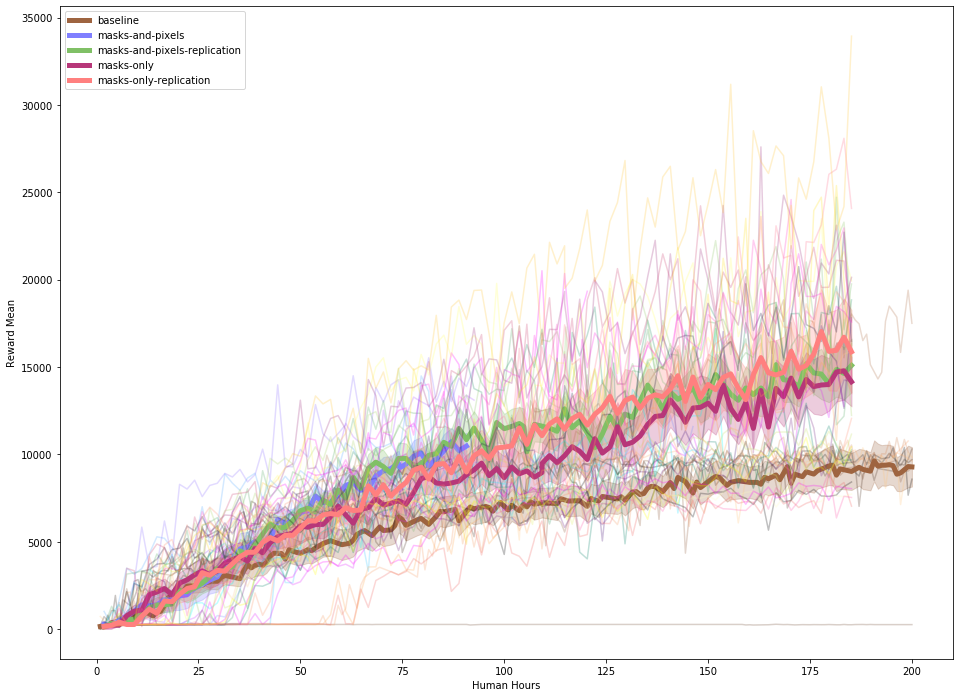

In [19]:
combined_plot(result_sets, max_hours=175)

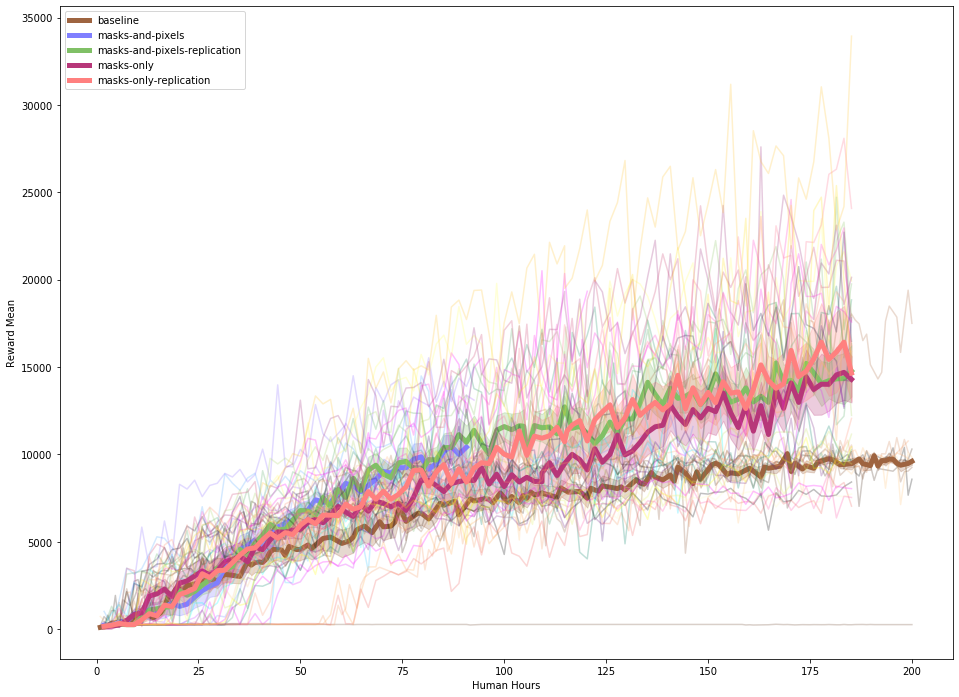

In [14]:
combined_plot(result_sets, drop_extrema=True)

array([[1, 2, 1],
       [3, 3, 2],
       [4, 5, 5]])

In [31]:
reward_mean_values[1:-1].shape

(8, 56)

In [ ]:
np.argmax(baseline_data[300]['human_hours'] > 100)

In [ ]:
min_max_index = 50
reward_mean_arr = np.array([val['reward_mean'][:min_max_index] for val in baseline_data.values()])

In [ ]:
reward_mean_arr.mean(axis=0).shape

In [ ]:
dir(baseline_data.items())

In [ ]:
initial_runs[0].config['seed']

In [ ]:
initial_runs[0].name, initial_runs[0].id 

In [ ]:
h = initial_runs[0].history()

In [ ]:
h['steps'].iat[-1]

In [ ]:
for existing_run in api.runs('augmented-frostbite/initial-experiments'):
    if existing_run.config['seed'] == 123:
        print(existing_run.history()['steps'])

In [ ]:
files = initial_runs[0].files()

In [ ]:
for f in initial_runs[0].files('config2.yaml'):
    print(f.name)

In [ ]:
initial_runs[0].file('config2.yaml')

In [ ]:
r = initial_runs[0]

In [ ]:
for r in api.runs('augmented-frostbite/initial-experiments'):
    print(r.name, r.storage_id)

In [ ]:
dir(initial_runs[0])

In [ ]:
tqdm.trange?

In [ ]:
s = 'cabac'

s == s[::-1]

In [ ]:
runs = api.runs('augmented-frostbite/initial-experiments', 
                {"$and": [{"config.id": "data-efficient-resume-test"}, {"config.seed": 200}]})
r = runs[0]

In [ ]:
h = r.history(samples=1000)

In [ ]:
h

In [ ]:
len(h)